Device: cpu


100%|██████████| 170M/170M [00:08<00:00, 20.1MB/s] 


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1185152e-08..1.0000001].


Images shape: torch.Size([128, 3, 32, 32])
Labels shape: torch.Size([128])


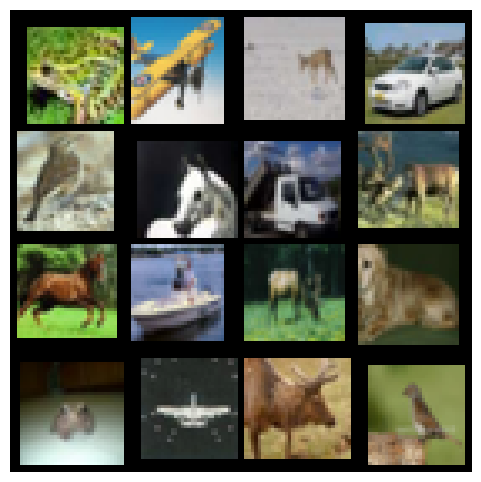

Labels (first 16): ['frog', 'airplane', 'deer', 'automobile', 'bird', 'horse', 'truck', 'deer', 'horse', 'ship', 'deer', 'dog', 'frog', 'airplane', 'deer', 'bird']
SimpleCNN(
  (features): Sequential(
    (0): ConvBlock(
      (net): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (net): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

KeyboardInterrupt: 

In [ ]:

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


config = {
    'batch_size': 128,
    'test_batch_size': 256,
    'lr': 1e-3,
    'weight_decay': 5e-4,
    'epochs': 20,
    'num_workers': 4,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print("Device:", config['device'])


mean = (0.4914, 0.4822, 0.4465)
std = (0.2470, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


DATA_DIR = './data'

train_dataset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=config['num_workers'])
test_loader = DataLoader(test_dataset, batch_size=config['test_batch_size'], shuffle=False, num_workers=config['num_workers'])

classes = train_dataset.classes
print('Classes:', classes)


import torchvision.utils as vutils

def imshow_batch(batch, labels, mean=mean, std=std):

    inv_normalize = transforms.Normalize(
        mean=[-m/s for m,s in zip(mean,std)],
        std=[1/s for s in std]
    )
    batch = inv_normalize(batch)
    grid = vutils.make_grid(batch[:16], nrow=4, padding=2)
    npimg = grid.numpy()
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)
print('Images shape:', images.shape)
print('Labels shape:', labels.shape)
imshow_batch(images, labels)
print('Labels (first 16):', [classes[l] for l in labels[:16]])



class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, padding=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=kernel_size, padding=padding, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
    def forward(self, x):
        return self.net(x)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            ConvBlock(3, 64),   
            ConvBlock(64, 128), 
            ConvBlock(128, 256),
            ConvBlock(256, 512) 
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), 
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model = SimpleCNN(num_classes=10).to(config['device'])
print(model)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)



def accuracy(output, target):
    with torch.no_grad():
        preds = output.argmax(dim=1)
        return (preds == target).float().mean().item()


def train_one_epoch(epoch, model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    n = 0
    for i, (inputs, targets) in enumerate(loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        b = inputs.size(0)
        running_loss += loss.item() * b
        running_acc += (outputs.argmax(dim=1) == targets).sum().item()
        n += b

    epoch_loss = running_loss / n
    epoch_acc = running_acc / n
    print(f"Epoch {epoch}: Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    n = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            b = inputs.size(0)
            running_loss += loss.item() * b
            running_acc += (outputs.argmax(dim=1) == targets).sum().item()
            n += b
    return running_loss / n, running_acc / n


train_losses = []
train_accs = []
val_losses = []
val_accs = []

start_time = datetime.now()
for epoch in range(1, config['epochs'] + 1):
    tr_loss, tr_acc = train_one_epoch(epoch, model, train_loader, optimizer, criterion, config['device'])
    val_loss, val_acc = evaluate(model, test_loader, criterion, config['device'])
    scheduler.step()

    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch}: Test Loss: {val_loss:.4f}, Test Acc: {val_acc:.4f}\n")

end_time = datetime.now()
print('Total training time:', end_time - start_time)


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='train_loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per epoch')

plt.subplot(1,2,2)
plt.plot(range(1, len(train_accs)+1), train_accs, label='train_acc')
plt.plot(range(1, len(val_accs)+1), val_accs, label='test_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per epoch')


os.makedirs('results', exist_ok=True)
plot_path = os.path.join('results', 'training_curves.png')
plt.savefig(plot_path)
plt.show()
print('Saved plot to', plot_path)




In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)


2.9.0+cpu
False
None
